In [1]:
import os
import json

import numpy
import matplotlib
from matplotlib import pyplot

from discohist import (
    fit_normal,
    fit_cabinetry,
    fit_linspace,
    fit_mcmc_mix,
    region,
)

In [2]:
BASENAME = "/home/tombs/Documents/interval-evidence/searches/atlas_susy_hb_2019/"

In [3]:
def load_reported():
    path = os.path.join(BASENAME, "reported.json")
    with open(path) as file_:
        reported = json.load(file_)
    return reported

REPORTED = load_reported()

In [4]:
def plot_fits(
    region_name,
    cabinetry_class=fit_cabinetry.FitCabinetry,
    normal_class=fit_normal.FitNormal,
    linspace_class=fit_linspace.FitLinspace,
    mcmc_class=fit_mcmc_mix.FitMcmcMix,
):
    print(region_name)
    path = os.path.join(BASENAME, region_name, "fit")
    
    region_i = region.Region.load(os.path.join(BASENAME, region_name))
    n_region = _get_n_region(region_i)
    
    n_reported = REPORTED[region_name]["n"]
    mismatch = ", !!!!!" * (n_region != n_reported)
    print("n = %d (%d%s)" % (n_reported, n_region, mismatch))
    
    bkg = REPORTED[region_name]["bkg"]
    bkg_hi = REPORTED[region_name]["bkg_hi"]
    bkg_lo = REPORTED[region_name]["bkg_lo"]
    print(f"bkg = {bkg:6.1f} {bkg_hi:+6.1f} {bkg_lo:+6.1f}")
    
    cabinetry = cabinetry_class.load(path)
    normal = normal_class.load(path)
    linspace = linspace_class.load(path)
    mcmc = mcmc_class.load(path)
    
    figure, axis = pyplot.subplots(tight_layout=(0, 0, 0))
    
    # TODO split to functions
    # TODO normalize to area, not maximum
    
    # plot reported
    axis.plot(
        [bkg + bkg_hi, bkg + bkg_lo],
        [-5] * 2,
        color="xkcd:barney purple",
        linewidth=2,
    )
    axis.scatter(
        [bkg], 
        [-5],
        s=10 ** 2,
        color="xkcd:barney purple",
        marker="*",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot cabinetry bar
    axis.plot(
        [
            cabinetry.yield_pre - cabinetry.error_pre, 
            cabinetry.yield_pre + cabinetry.error_pre,
        ],
        [-4] * 2,
        color="xkcd:mahogany",
        linewidth=2,
    )
    axis.scatter(
        [cabinetry.yield_pre], 
        [-4],
        s=10 ** 2,
        color="xkcd:mahogany",
        marker="o",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot normal bar
    axis.plot(
        [
            normal.yield_linear - normal.error_linear, 
            normal.yield_linear + normal.error_linear,
        ],
        [-3] * 2,
        "k",
        linewidth=2,
    )
    axis.scatter(
        [normal.yield_linear], 
        [-3],
        s=10 ** 2,
        color="k",
        marker="D",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot linear
    linspace_levels = numpy.array(linspace.levels)
    linspace_logy = linspace_levels.min() - linspace_levels
    linspace_x = numpy.linspace(linspace.start, linspace.stop, len(linspace.levels))
    pyplot.plot(
        linspace_x, 
        linspace_logy,
        "b",
        linewidth=2,
    )
    
    # plot mcmc
    nbins = 50
    mcmc_x = numpy.linspace(*mcmc.range_, nbins + 1)
    yields = _rebin(mcmc.yields, nbins)
    mcmc_yields = numpy.append(yields, yields[-1])
    scale = yields.max()
    mcmc_y = _safe_log(mcmc_yields / scale)
    pyplot.plot(
        mcmc_x,
        mcmc_y,
        "r",
        linewidth=2,
        drawstyle="steps-post",
    )

    xmin = min(linspace.start, mcmc.range_[0])
    xmax = max(linspace.stop, mcmc.range_[1])
    pyplot.xlim(xmin, xmax)
    pyplot.ylim(-8, 0.5)
    
    pyplot.show()
    
    
def _rebin(array, len_new):
    return numpy.reshape(array, (len_new, -1)).sum(axis=-1)

    
def _safe_log(x):
    is_zero = x == 0
    return numpy.where(
        is_zero,
        -numpy.inf,
        numpy.log(x + is_zero),
    )


def _get_n_region(reg):
    sr_name = reg.signal_region_name
    observations = reg.workspace

    for obs in reg.workspace["observations"]:
        if obs["name"] == sr_name:
            return obs["data"][0]

    raise ValueError(sr_name)

SRA
n = 17 (17)
bkg =   17.1   +2.8   -2.8


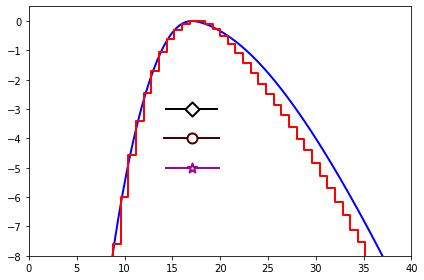

SRB
n = 3 (3)
bkg =    3.3   +0.9   -0.9


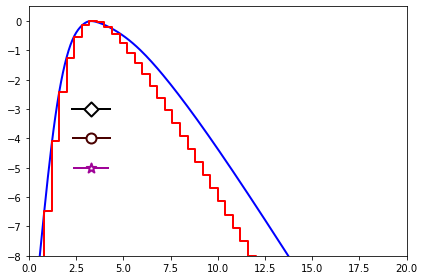

SRC
n = 47 (47)
bkg =   37.9   +6.2   -6.2


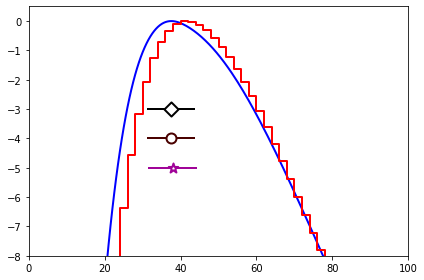

In [5]:
def main():
    for sr_name in REPORTED:
        plot_fits(sr_name)

main()